Please upload missing file: X_train.csv


Saving X_train.csv to X_train.csv
Please upload missing file: X_test.csv


Saving X_test.csv to X_test.csv
Please upload missing file: Y_train.csv


Saving Y_train.csv to Y_train.csv
Please upload missing file: Y_test.csv


Saving Y_test.csv to Y_test.csv
✅ Shapes:
X_train: torch.Size([146831, 1, 6])
Y_train: torch.Size([146831])
X_test: torch.Size([36707, 1, 6])
Y_test: torch.Size([36707])

🚀 Training GRU Model with Early Stopping...

📈 Epoch 01/100 - Loss: 0.6964, Val Accuracy: 51.10%
📈 Epoch 02/100 - Loss: 0.6920, Val Accuracy: 56.04%
📈 Epoch 03/100 - Loss: 0.6876, Val Accuracy: 60.44%
📈 Epoch 04/100 - Loss: 0.6832, Val Accuracy: 66.47%
📈 Epoch 05/100 - Loss: 0.6788, Val Accuracy: 69.93%
📈 Epoch 06/100 - Loss: 0.6745, Val Accuracy: 76.77%
📈 Epoch 07/100 - Loss: 0.6701, Val Accuracy: 81.10%
📈 Epoch 08/100 - Loss: 0.6658, Val Accuracy: 83.76%
📈 Epoch 09/100 - Loss: 0.6614, Val Accuracy: 88.21%
📈 Epoch 10/100 - Loss: 0.6571, Val Accuracy: 90.25%
📈 Epoch 11/100 - Loss: 0.6527, Val Accuracy: 91.34%
📈 Epoch 12/100 - Loss: 0.6483, Val Accuracy: 91.37%
📈 Epoch 13/100 - Loss: 0.6440, Val Accuracy: 91.37%
📈 Epoch 14/100 - Loss: 0.6396, Val Accuracy: 91.37%
📈 Epoch 15/100 - Loss: 0.6352, Val Accuracy: 91.37%
📈 Ep

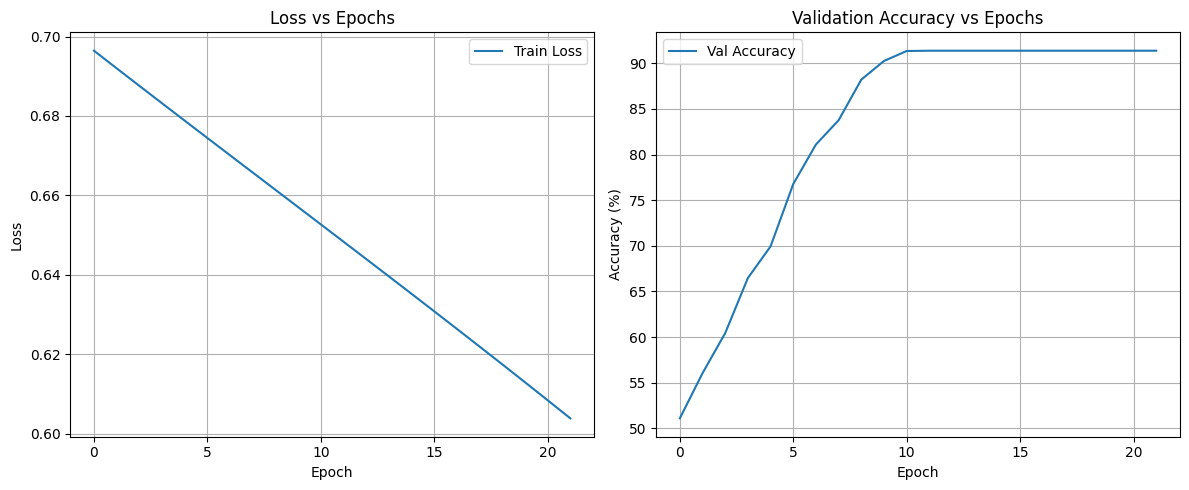

In [ ]:
# === SAME INITIAL SETUP ===
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ==== STEP 1: Upload CSV if needed ====
file_names = ["X_train.csv", "X_test.csv", "Y_train.csv", "Y_test.csv"]
for name in file_names:
    if not os.path.exists(name):
        print(f"Please upload missing file: {name}")
        from google.colab import files
        uploaded = files.upload()
        for fname in uploaded:
            with open(fname.split(" (")[0], 'wb') as f:
                f.write(uploaded[fname])

# ==== STEP 2: Load and reshape ====
X_train = pd.read_csv("X_train.csv").values
X_test = pd.read_csv("X_test.csv").values
Y_train = pd.read_csv("Y_train.csv")
Y_test = pd.read_csv("Y_test.csv")

Y_train = Y_train.iloc[:, 0] if Y_train.shape[1] > 1 else Y_train.squeeze()
Y_test = Y_test.iloc[:, 0] if Y_test.shape[1] > 1 else Y_test.squeeze()
Y_train = Y_train.values.ravel()
Y_test = Y_test.values.ravel()

# ==== STEP 3: Convert to tensors ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.long).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)

print("✅ Shapes:")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)

# ==== STEP 4: Define GRU model ====
class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

model = GRUNet(input_size=X_train.shape[2], hidden_size=64, output_size=len(np.unique(Y_train))).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==== STEP 5: Training with Early Stopping ====
epochs = 100
patience = 10
delta = 1e-4
train_losses, val_accuracies = [], []

best_acc = 0
counter = 0
start_repeat_epoch = None
best_model_state = model.state_dict()

print("\n🚀 Training GRU Model with Early Stopping...\n")

for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, Y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test).argmax(dim=1)
        val_acc = accuracy_score(Y_test.cpu(), val_preds.cpu()) * 100

    train_losses.append(loss.item())
    val_accuracies.append(val_acc)

    print(f"📈 Epoch {epoch:02d}/{epochs} - Loss: {loss.item():.4f}, Val Accuracy: {val_acc:.2f}%")

    # Early stopping logic
    if abs(val_acc - best_acc) < delta:
        counter += 1
        if counter == 1:
            start_repeat_epoch = epoch
        if counter >= patience:
            print(f"\n🛑 Early stopping triggered after {patience} epochs with no significant accuracy change.")
            print(f"✅ Accuracy converged from Epoch {start_repeat_epoch} to {epoch} at ~{val_acc:.2f}%")
            break
    else:
        best_acc = val_acc
        counter = 0
        start_repeat_epoch = None
        best_model_state = model.state_dict()

# ==== STEP 6: Evaluate final model ====
model.load_state_dict(best_model_state)
model.eval()
test_preds = model(X_test).argmax(dim=1)
test_acc = accuracy_score(Y_test.cpu(), test_preds.cpu()) * 100
print(f"\n✅ Final Test Accuracy (Best Model): {test_acc:.2f}%")

# ==== STEP 7: Plot Results ====
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Step 1: Load the dataset from CSV files
X_train = pd.read_csv('X_train.csv').values
X_test = pd.read_csv('X_test.csv').values
y_train = pd.read_csv('Y_train.csv').values.flatten()  # Flatten to a 1D array
y_test = pd.read_csv('Y_test.csv').values.flatten()    # Flatten to a 1D array

# Step 2: Convert y to one-hot encoded labels
lb = LabelBinarizer()
y_train_one_hot = lb.fit_transform(y_train)
y_test_one_hot = lb.transform(y_test)

# Step 3: Initialize parameters
n_trees = 100  # Number of boosting iterations (trees)
learning_rate = 0.1  # Learning rate for boosting
max_depth = 3  # Maximum depth of the decision trees
n_classes = len(np.unique(y_train))  # Number of classes in the dataset

# Step 4: Initialize the model with constant predictions (mean of the labels)
F_train = np.zeros(y_train_one_hot.shape)

# Step 5: Initialize the trees and start the boosting iterations
trees = []
for i in range(n_trees):
    # Step 5.1: Compute the residuals (negative gradients) for each class
    residuals = y_train_one_hot - F_train  # This is the error for each iteration

    # Step 5.2: Fit a decision tree for each class separately
    tree_models = []
    for class_idx in range(n_classes):
        tree = DecisionTreeRegressor(max_depth=max_depth)
        tree.fit(X_train, residuals[:, class_idx])  # Train on residuals for each class
        tree_models.append(tree)

    # Step 5.3: Update the model predictions (F_train) for each class
    for class_idx in range(n_classes):
        tree_predictions = tree_models[class_idx].predict(X_train)
        F_train[:, class_idx] += learning_rate * tree_predictions  # Update class-wise prediction

    # Store the trees for later use
    trees.append(tree_models)

    # Optionally print progress
    if (i + 1) % 10 == 0:
        print(f"Iteration {i+1} / {n_trees} complete.")

# Step 6: Final predictions on the training set
y_pred = np.argmax(F_train, axis=1)  # Take the class with the highest predicted score

# Step 7: Calculate accuracy
accuracy = accuracy_score(y_train, y_pred)
print(f"Final Training Accuracy: {accuracy * 100:.2f}%")

# Step 8: Final predictions on the test set
F_test = np.zeros(y_test_one_hot.shape)
for tree_models in trees:
    for class_idx in range(n_classes):
        tree_predictions = tree_models[class_idx].predict(X_test)
        F_test[:, class_idx] += learning_rate * tree_predictions  # Update class-wise prediction

# Convert predictions to class labels
y_pred_test = np.argmax(F_test, axis=1)

# Step 9: Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Step 10: Confusion Matrix (Optional)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


ValueError: Number of labels=1761972 does not match number of samples=146831